### Grace Lessig, Samantha Chai, Samantha Candelo-Ortegon, Chi Le

## Importing and Cleaning Datasets

In [1]:
# import all necessary libraries
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [9]:
# import all datasets from kaggle
original_bechdel_df = pd.read_csv('Bechdel_IMDB_Merge0524.csv', index_col=0)
original_movies_df = pd.read_csv('movies.csv', index_col=0)

# set movie titles as indexes
original_movies_df= original_movies_df.set_index("title")

# clean each indivdual dataset
clean_bechdel_df = original_bechdel_df[["year", "bechdelRating", "imdbAverageRating", "runtimeMinutes", "genre1"]]
clean_movies_df = original_movies_df[["budget", "domgross", "intgross"]]

# find movie titles that are common amongst all data sets
common_titles = []

for movie_title in clean_bechdel_df.index.tolist():
    if movie_title in movie_title in clean_movies_df.index.tolist():
        common_titles.append(movie_title)

common_titles = sorted(common_titles)

# reduce cleaned dataframes to just those in common
clean_bechdel_df = clean_bechdel_df.loc[common_titles]
clean_movies_df = clean_movies_df.loc[common_titles]

# combine all the cleaned datatsets into one (reset indexes for potential errors that might arise)
reset_bechdel_df = clean_bechdel_df.reset_index()
reset_movies_df = clean_movies_df.reset_index()

combined_movies_df = reset_bechdel_df.merge(reset_movies_df, on="title", how="inner")
combined_movies_df.set_index("title", inplace=True)

# make dataframe cohesive in style
combined_movies_df.rename(columns={"year": "release_year"}, inplace=True)
combined_movies_df.rename(columns={"bechdelRating": "bechdel_rating"}, inplace=True)
combined_movies_df.rename(columns={"imdbAverageRating": "imdb_average_rating"}, inplace=True)
combined_movies_df.rename(columns={"runtimeMinutes": "duration"}, inplace=True)
combined_movies_df.rename(columns={"genre1": "genre"}, inplace=True)
combined_movies_df.rename(columns={"domgross": "domestic_gross"}, inplace=True)
combined_movies_df.rename(columns={"intgross": "international_gross"}, inplace=True)

# drop duplicates
combined_movies_df.drop_duplicates(inplace=True)

# put dataframe into csv for easy referencing
combined_movies_df.to_csv("combined_movies.csv", index=True)

# create a decade column
combined_movies_df['decade'] = (combined_movies_df['release_year'] // 10) * 10

# create a pass/fail column
combined_movies_df['bechdel_pass'] = combined_movies_df['bechdel_rating'].apply(lambda x: 1 if x == 3 else 0)
combined_movies_df

,release_year,bechdel_rating,imdb_average_rating,duration,genre,budget,domestic_gross,international_gross,decade,bechdel_pass
title,,,,,,,,,,
(500) Days of Summer,2009,1,7.7,95,Comedy,7500000,32391374.0,60803210.0,2000,0
10 Things I Hate About You,1999,3,7.3,97,Comedy,13000000,38177966.0,60414025.0,1990,1
12 Years a Slave,2013,3,8.1,134,Biography,20000000,53107035.0,158607035.0,2010,1
127 Hours,2010,3,7.5,94,Biography,18000000,18335230.0,60735230.0,2010,1
13 Going on 30,2004,3,6.3,98,Comedy,30000000,57139723.0,96439723.0,2000,1
...,...,...,...,...,...,...,...,...,...,...
Zoolander,2001,3,6.5,90,Comedy,28000000,45172250.0,60780981.0,2000,1
Zoom,2006,3,4.4,83,Action,35000000,11989328.0,12506188.0,2000,1
Zwartboek,2006,3,7.7,145,Drama,22000000,4398532.0,27238354.0,2000,1


In [10]:
combined_movies_df.count()
combined_movies_df.head()

,release_year,bechdel_rating,imdb_average_rating,duration,genre,budget,domestic_gross,international_gross,decade,bechdel_pass
title,,,,,,,,,,
(500) Days of Summer,2009,1,7.7,95,Comedy,7500000,32391374.0,60803210.0,2000,0
10 Things I Hate About You,1999,3,7.3,97,Comedy,13000000,38177966.0,60414025.0,1990,1
12 Years a Slave,2013,3,8.1,134,Biography,20000000,53107035.0,158607035.0,2010,1
127 Hours,2010,3,7.5,94,Biography,18000000,18335230.0,60735230.0,2010,1
13 Going on 30,2004,3,6.3,98,Comedy,30000000,57139723.0,96439723.0,2000,1


In [11]:
def assign_period(year):
    if year <= 1985:
        return 'pre-bechdel'
    elif year > 1985:
        return 'post-bechdel'

combined_movies_df['period'] = combined_movies_df['release_year'].apply(assign_period)
combined_movies_df.head()

,release_year,bechdel_rating,imdb_average_rating,duration,genre,budget,domestic_gross,international_gross,decade,bechdel_pass,period
title,,,,,,,,,,,
(500) Days of Summer,2009,1,7.7,95,Comedy,7500000,32391374.0,60803210.0,2000,0,post-bechdel
10 Things I Hate About You,1999,3,7.3,97,Comedy,13000000,38177966.0,60414025.0,1990,1,post-bechdel
12 Years a Slave,2013,3,8.1,134,Biography,20000000,53107035.0,158607035.0,2010,1,post-bechdel
127 Hours,2010,3,7.5,94,Biography,18000000,18335230.0,60735230.0,2010,1,post-bechdel
13 Going on 30,2004,3,6.3,98,Comedy,30000000,57139723.0,96439723.0,2000,1,post-bechdel


## Bar Charts Visualization

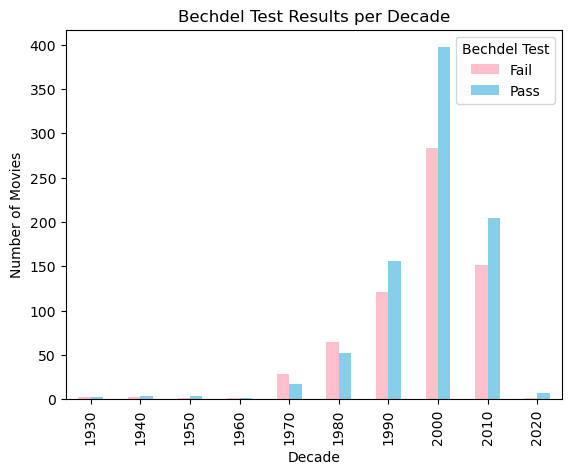

In [12]:
# bechdel test rating per decade
counted_df = combined_movies_df.groupby(['decade', 'bechdel_pass']).size().unstack(fill_value=0)

counted_df.plot(kind='bar', color=["pink", "skyblue"]) 
plt.title("Bechdel Test Results per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.legend(["Fail", "Pass"], title="Bechdel Test")
plt.show()

/var/folders/hr/ng5xcnbs46z64k8n1ytjd3gr0000gn/T/ipykernel_35700/2507317822.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=copy_bechdel_df, x="bechdel_pass", y="imdbAverageRating", ci="sd", palette=["pink", "skyblue"])


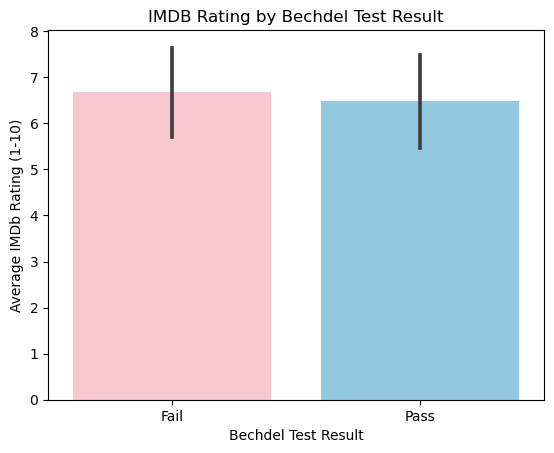

In [13]:
# imbd rating per bechdel passing (from just IMDB dataset)
copy_bechdel_df = original_bechdel_df.copy()
copy_bechdel_df["bechdel_pass"] = copy_bechdel_df['bechdelRating'].apply(lambda x: "Pass" if x == 3 else "Fail")

sns.barplot(data=copy_bechdel_df, x="bechdel_pass", y="imdbAverageRating", ci="sd", palette=["pink", "skyblue"])
plt.title("IMDB Rating by Bechdel Test Result")
plt.xlabel("Bechdel Test Result")
plt.ylabel("Average IMDb Rating (1-10)")
plt.show()

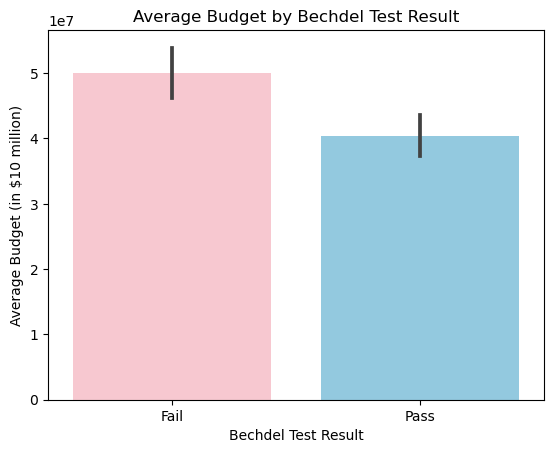

In [14]:
# budget per bechdel - (movies.csv dataset)
copy_df = combined_movies_df.copy()
copy_df["bechdel_pass"] = copy_df['bechdel_rating'].apply(lambda x: "Pass" if x == 3 else "Fail")

sns.barplot(data=copy_df, x="bechdel_pass", y="budget", palette=["pink", "skyblue"])
plt.title("Average Budget by Bechdel Test Result")
plt.xlabel("Bechdel Test Result")
plt.ylabel("Average Budget (in $10 million)")
plt.show()

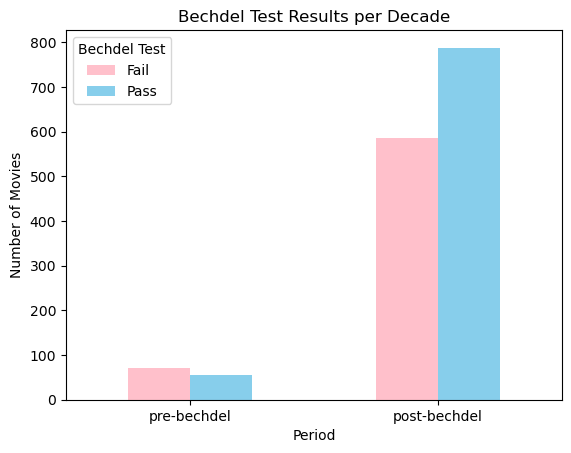

In [18]:
# bechdel ratings before and after test release
copy_df_2 = combined_movies_df.groupby(['period', 'bechdel_pass']).size().unstack(fill_value=0)
copy_df_2 = copy_df_2.loc[["pre-bechdel", "post-bechdel"]]

copy_df_2.plot(kind='bar', color=["pink", "skyblue"])
plt.title("Bechdel Test Results per Decade")
plt.xlabel("Period")
plt.ylabel("Number of Movies")
plt.legend(["Fail", "Pass"], title="Bechdel Test")
plt.xticks(rotation=0)
plt.show()

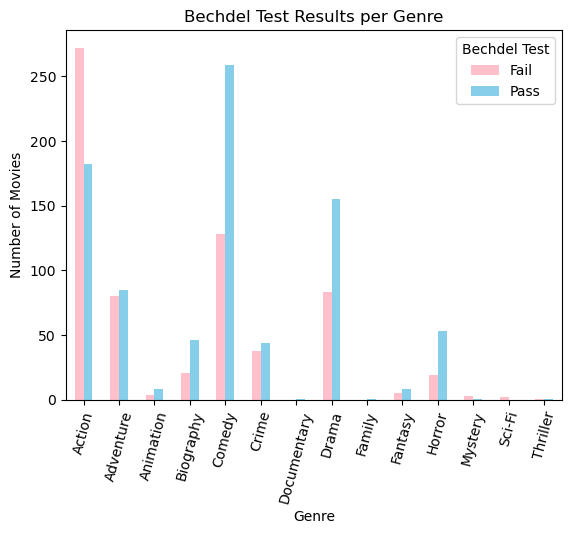

In [17]:
# bechdel test rating per genre
copy_3_df = combined_movies_df.groupby(['genre', 'bechdel_pass']).size().unstack(fill_value=0)

copy_3_df.plot(kind='bar', color=["pink", "skyblue"]) 
plt.title("Bechdel Test Results per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.legend(["Fail", "Pass"], title="Bechdel Test")
plt.xticks(rotation=75)
plt.show()

## Line Plot Visualization

### In each graph, we are plotting decade amongst other numerical variables with the Bechdel test being represented through colors

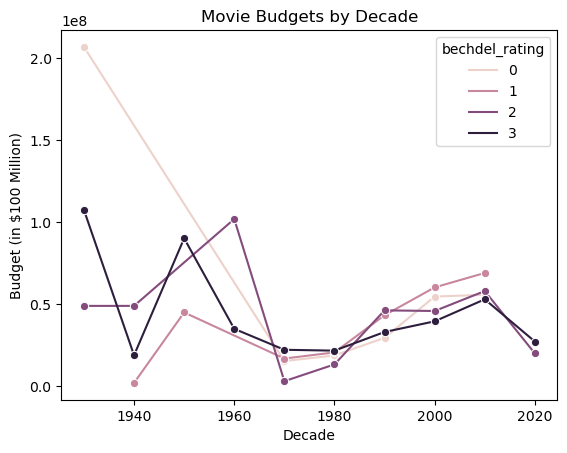

In [10]:
# Decade by Budget
avg_by_decade = combined_movies_df.groupby(['decade', 'bechdel_rating']).mean(numeric_only=True).reset_index()
sns.lineplot(data=avg_by_decade, x='decade', y='budget', hue='bechdel_rating', marker='o')
plt.title("Movie Budgets by Decade")
plt.xlabel("Decade")
plt.ylabel("Budget (in $100 Million)")
plt.show()

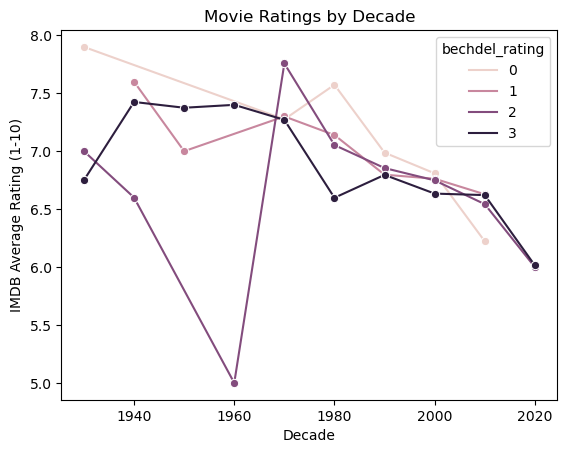

In [11]:
# Decade by Average Rating
sns.lineplot(data=avg_by_decade, x='decade', y='imdb_average_rating', hue='bechdel_rating', marker='o')
plt.title("Movie Ratings by Decade")
plt.xlabel("Decade")
plt.ylabel("IMDB Average Rating (1-10)")
plt.show()

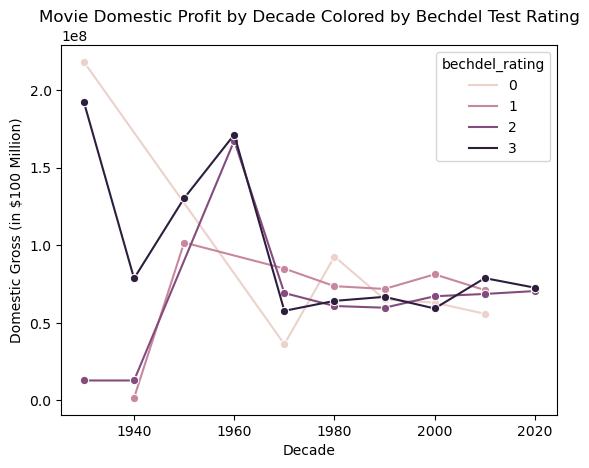

In [12]:
# Decade by Domestic Gross
sns.lineplot(data=avg_by_decade, x='decade', y='domestic_gross', hue='bechdel_rating', marker='o')
plt.title("Movie Domestic Profit by Decade Colored by Bechdel Test Rating")
plt.xlabel("Decade")
plt.ylabel("Domestic Gross (in $100 Million)")
plt.show()

## Complex Networks

### We use complex networks to try to visualize the data

In [19]:
movie_decade = combined_movies_df.reset_index()[['decade', 'title']].copy()
movie_decade_grouped = movie_decade.groupby('decade')
    
def getDecade(decade, movie_decade_grouped):
    decade_movies = movie_decade_grouped.get_group(decade)['title']
    return decade_movies.tolist()
    
def getGenre(genre_name, movie_genres_grouped):
    genre_movies = movie_genres_grouped.get_group(genre_name)['title']
    return genre_movies.tolist()

In [20]:
W = nx.Graph()
for decade, group in movie_decade_grouped:
    movies = getGenre(decade, movie_decade_grouped)
    for i in range(len(movies)):
        
        for j in range(i + 1, len(movies)):  # ensures no self-loops and no duplicate edges
            movie1 = movies[i]
            movie2 = movies[j]
            W.add_edge(movie1, movie2)

In [21]:
# quick exploration of the network.
print("number of nodes:", len(W.nodes()))
print("number of edges:", len(W.edges()))
print("average degree:", (2*len(W.edges()))/len(W.nodes()))

number of nodes: 1430
number of edges: 337571
average degree: 472.1272727272727


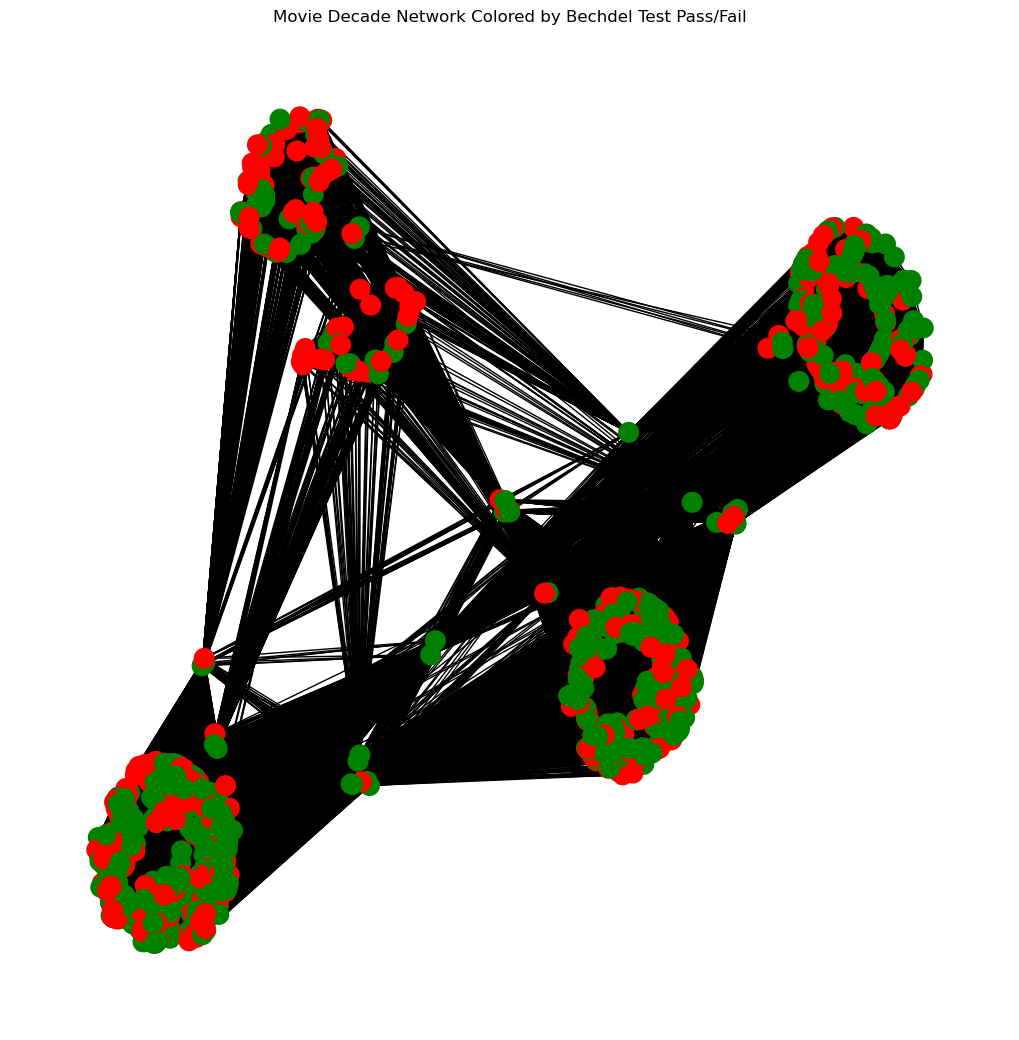

In [22]:
node_colors = []

for node in W.nodes():
    row = combined_movies_df.loc[combined_movies_df.index == node]
    if not row.empty and row.iloc[0]['bechdel_pass'] == 1:
        node_colors.append('green')
    else:
        node_colors.append('red')

pos = nx.spring_layout(W, seed=42)
plt.figure(figsize=(10, 10))
nx.draw(W, pos=pos, node_color=node_colors, node_size=200)
plt.title("Movie Decade Network Colored by Bechdel Test Pass/Fail")
plt.show()

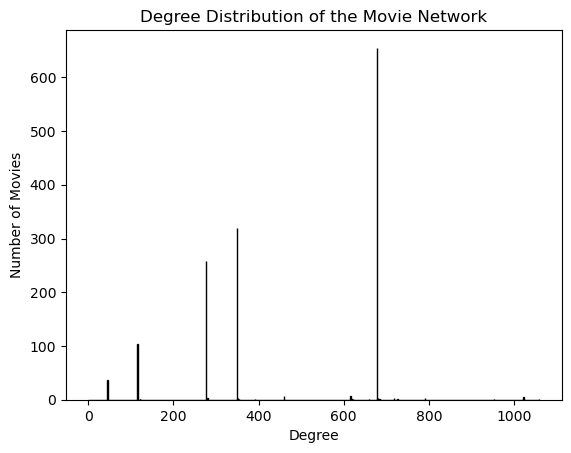

In [23]:
# plot the degree distribution of the network
degrees = [degree for node, degree in W.degree()]

plt.hist(degrees, bins=range(1, max(degrees)+2), edgecolor='black', align='left')
plt.title("Degree Distribution of the Movie Network")
plt.xlabel("Degree")
plt.ylabel("Number of Movies")
plt.show()

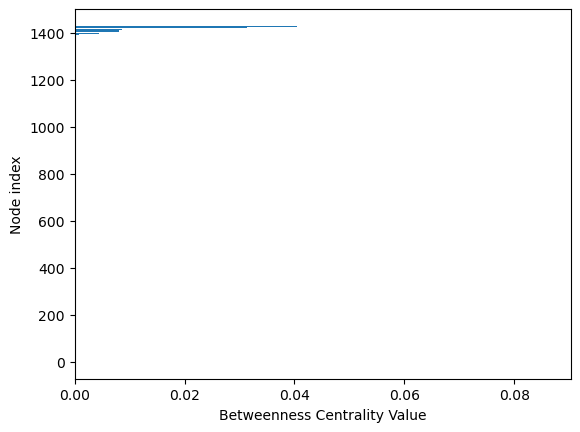

In [24]:
# plot the betweenness centrality of the network
b_values2 = nx.betweenness_centrality(W)
b_values2_sorted = sorted(b_values2.values())

plt.barh(range(len(b_values2_sorted)), b_values2_sorted)
plt.xlabel("Betweenness Centrality Value")
plt.ylabel("Node index")
plt.show()

## Model Training

### Here, we train different types of models too see which gives the best accuracy

In [25]:
# create a new column for profit (international + domestic - budget)
combined_movies_df['total_gross'] = combined_movies_df[['domestic_gross', 'international_gross']].sum(axis=1)
combined_movies_df['profit'] = combined_movies_df['total_gross'] - combined_movies_df['budget']

# drop rows with any missing data in predictors or target
df = combined_movies_df.dropna(subset=['imdb_average_rating', 'budget', 'profit', 'bechdel_rating'])
df.head()

,release_year,bechdel_rating,imdb_average_rating,duration,genre,budget,domestic_gross,international_gross,decade,bechdel_pass,period,total_gross,profit
title,,,,,,,,,,,,,
(500) Days of Summer,2009,1,7.7,95,Comedy,7500000,32391374.0,60803210.0,2000,0,post-bechdel,93194584.0,85694584.0
10 Things I Hate About You,1999,3,7.3,97,Comedy,13000000,38177966.0,60414025.0,1990,1,post-bechdel,98591991.0,85591991.0
12 Years a Slave,2013,3,8.1,134,Biography,20000000,53107035.0,158607035.0,2010,1,post-bechdel,211714070.0,191714070.0
127 Hours,2010,3,7.5,94,Biography,18000000,18335230.0,60735230.0,2010,1,post-bechdel,79070460.0,61070460.0
13 Going on 30,2004,3,6.3,98,Comedy,30000000,57139723.0,96439723.0,2000,1,post-bechdel,153579446.0,123579446.0


In [26]:
# define features and target, and split data
X = df[['duration', 'budget', 'profit', 'release_year']]
y = df['bechdel_pass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# decision tree model
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5966666666666667
Confusion matrix:
 [[ 63  63]
 [ 58 116]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.50      0.51       126
           1       0.65      0.67      0.66       174

    accuracy                           0.60       300
   macro avg       0.58      0.58      0.58       300
weighted avg       0.59      0.60      0.60       300



In [28]:
# random forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5866666666666667
Confusion matrix:
 [[ 60  66]
 [ 58 116]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.48      0.49       126
           1       0.64      0.67      0.65       174

    accuracy                           0.59       300
   macro avg       0.57      0.57      0.57       300
weighted avg       0.58      0.59      0.58       300



In [29]:
# logistic regression model

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6133333333333333
Confusion matrix:
 [[ 29  97]
 [ 19 155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.23      0.33       126
           1       0.62      0.89      0.73       174

    accuracy                           0.61       300
   macro avg       0.61      0.56      0.53       300
weighted avg       0.61      0.61      0.56       300



In [30]:
# k-nearest-neighbors model (without scaling the data)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5866666666666667
Confusion matrix:
 [[ 59  67]
 [ 57 117]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.47      0.49       126
           1       0.64      0.67      0.65       174

    accuracy                           0.59       300
   macro avg       0.57      0.57      0.57       300
weighted avg       0.58      0.59      0.58       300



In [31]:
# k-nearest-neighbors model (with scaling the data)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5766666666666667
Confusion matrix:
 [[ 53  73]
 [ 54 120]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.42      0.45       126
           1       0.62      0.69      0.65       174

    accuracy                           0.58       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.57      0.58      0.57       300



### Now we will filter the data to see if it gives us a more accurate model

In [32]:
# fitler data
filtered_df = combined_movies_df[(combined_movies_df['decade'] >= 1970) & (combined_movies_df['decade'] <= 2010)]
filtered_avg_by_decade = avg_by_decade[(avg_by_decade['decade'] >= 1970) & (avg_by_decade['decade'] <= 2010)]

In [33]:
filtered_df.head()

,release_year,bechdel_rating,imdb_average_rating,duration,genre,budget,domestic_gross,international_gross,decade,bechdel_pass,period,total_gross,profit
title,,,,,,,,,,,,,
(500) Days of Summer,2009,1,7.7,95,Comedy,7500000,32391374.0,60803210.0,2000,0,post-bechdel,93194584.0,85694584.0
10 Things I Hate About You,1999,3,7.3,97,Comedy,13000000,38177966.0,60414025.0,1990,1,post-bechdel,98591991.0,85591991.0
12 Years a Slave,2013,3,8.1,134,Biography,20000000,53107035.0,158607035.0,2010,1,post-bechdel,211714070.0,191714070.0
127 Hours,2010,3,7.5,94,Biography,18000000,18335230.0,60735230.0,2010,1,post-bechdel,79070460.0,61070460.0
13 Going on 30,2004,3,6.3,98,Comedy,30000000,57139723.0,96439723.0,2000,1,post-bechdel,153579446.0,123579446.0


In [34]:
filtered_df.count()

release_year           1475
bechdel_rating         1475
imdb_average_rating    1475
duration               1475
genre                  1475
budget                 1475
domestic_gross         1462
international_gross    1468
decade                 1475
bechdel_pass           1475
period                 1475
total_gross            1475
profit                 1475
dtype: int64

### Let's redo the line visualizations with this filtered data

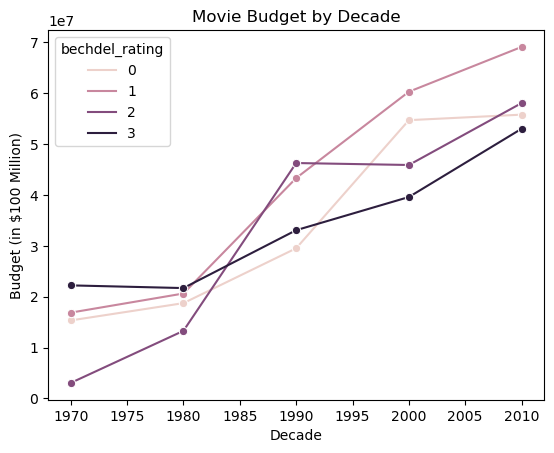

In [35]:
sns.lineplot(data=filtered_avg_by_decade, x='decade', y='budget', hue='bechdel_rating', marker='o')
plt.title("Movie Budget by Decade")
plt.xlabel("Decade")
plt.ylabel("Budget (in $100 Million)")
plt.show()

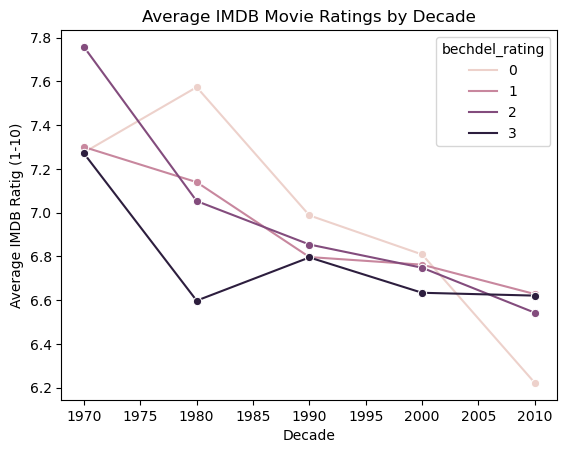

In [36]:
sns.lineplot(data=filtered_avg_by_decade, x='decade', y='imdb_average_rating', hue='bechdel_rating', marker='o')
plt.title("Average IMDB Movie Ratings by Decade")
plt.xlabel("Decade")
plt.ylabel("Average IMDB Ratig (1-10)")
plt.show()

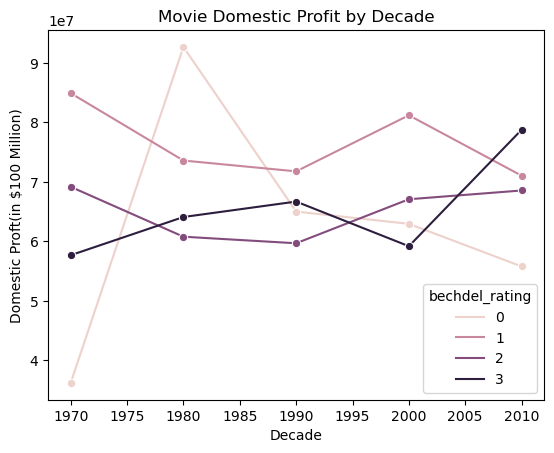

In [37]:
sns.lineplot(data=filtered_avg_by_decade, x='decade', y='domestic_gross', hue='bechdel_rating', marker='o')
plt.title("Movie Domestic Profit by Decade")
plt.xlabel("Decade")
plt.ylabel("Domestic Proft(in $100 Million)")
plt.show()

### And rerun our models with the filtered data

In [38]:
# drop rows with any missing data in predictors or target
filtered_df = filtered_df.dropna(subset=['imdb_average_rating', 'budget', 'profit', 'bechdel_rating'])

In [39]:
X = filtered_df[['duration', 'budget', 'profit', 'release_year']]
y = filtered_df['bechdel_pass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# decision tree model
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5966101694915255
Confusion matrix:
 [[ 40  78]
 [ 41 136]]
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.34      0.40       118
           1       0.64      0.77      0.70       177

    accuracy                           0.60       295
   macro avg       0.56      0.55      0.55       295
weighted avg       0.58      0.60      0.58       295



In [41]:
# random forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5694915254237288
Confusion matrix:
 [[ 58  60]
 [ 67 110]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.49      0.48       118
           1       0.65      0.62      0.63       177

    accuracy                           0.57       295
   macro avg       0.56      0.56      0.56       295
weighted avg       0.57      0.57      0.57       295



In [42]:
# logistic regression model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5966101694915255
Confusion matrix:
 [[ 33  85]
 [ 34 143]]
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.28      0.36       118
           1       0.63      0.81      0.71       177

    accuracy                           0.60       295
   macro avg       0.56      0.54      0.53       295
weighted avg       0.57      0.60      0.57       295



In [43]:
# k-nearest-neighbors model (without scaling the data)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5220338983050847
Confusion matrix:
 [[ 52  66]
 [ 75 102]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.44      0.42       118
           1       0.61      0.58      0.59       177

    accuracy                           0.52       295
   macro avg       0.51      0.51      0.51       295
weighted avg       0.53      0.52      0.52       295



In [44]:
# k-nearest-neighbors model (with scaling the data)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.576271186440678
Confusion matrix:
 [[ 61  57]
 [ 68 109]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.52      0.49       118
           1       0.66      0.62      0.64       177

    accuracy                           0.58       295
   macro avg       0.56      0.57      0.56       295
weighted avg       0.58      0.58      0.58       295



### Now we will incorporate genres onto the models by hot encoding them.

In [45]:
# making copy of df (unfiltered)
combined_df_with_genres = df.copy()

# grouping the genres with low counts together into 'Other'
other_genres = ['Fantasy', 'Animation', 'Mystery', 'Thriller', 'Sci-Fi', 'Family', 'Documentary']
combined_df_with_genres['genre'] = combined_df_with_genres['genre'].apply(lambda x: 'Other' if x in other_genres else x)
combined_df_with_genres['genre'].value_counts()

Action       454
Comedy       387
Drama        238
Adventure    165
Crime         82
Horror        72
Biography     67
Other         35
Name: genre, dtype: int64

In [46]:
# hot encoding the genres
# from sklearn OneHotEncoder documentation and Ryan & Matt Data Science page
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(combined_df_with_genres[['genre']])
combined_df_with_genres = pd.concat([combined_df_with_genres, one_hot_encoded], axis=1)
combined_df_with_genres.head(5)

,release_year,bechdel_rating,imdb_average_rating,duration,genre,budget,domestic_gross,international_gross,decade,bechdel_pass,...,total_gross,profit,genre_Action,genre_Adventure,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Horror,genre_Other
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,2009,1,7.7,95,Comedy,7500000,32391374.0,60803210.0,2000,0,...,93194584.0,85694584.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10 Things I Hate About You,1999,3,7.3,97,Comedy,13000000,38177966.0,60414025.0,1990,1,...,98591991.0,85591991.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12 Years a Slave,2013,3,8.1,134,Biography,20000000,53107035.0,158607035.0,2010,1,...,211714070.0,191714070.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
127 Hours,2010,3,7.5,94,Biography,18000000,18335230.0,60735230.0,2010,1,...,79070460.0,61070460.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13 Going on 30,2004,3,6.3,98,Comedy,30000000,57139723.0,96439723.0,2000,1,...,153579446.0,123579446.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [47]:
X = combined_df_with_genres[['duration', 'budget', 'profit', 'release_year','genre_Action','genre_Adventure','genre_Biography',
                             'genre_Comedy','genre_Crime','genre_Drama','genre_Horror','genre_Other']]

y = combined_df_with_genres['bechdel_pass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# decision tree model
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6333333333333333
Confusion matrix:
 [[ 62  64]
 [ 46 128]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.49      0.53       126
           1       0.67      0.74      0.70       174

    accuracy                           0.63       300
   macro avg       0.62      0.61      0.61       300
weighted avg       0.63      0.63      0.63       300



In [49]:
# random forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6366666666666667
Confusion matrix:
 [[ 66  60]
 [ 49 125]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.52      0.55       126
           1       0.68      0.72      0.70       174

    accuracy                           0.64       300
   macro avg       0.62      0.62      0.62       300
weighted avg       0.63      0.64      0.63       300



In [50]:
# logistic regression model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6333333333333333
Confusion matrix:
 [[ 61  65]
 [ 45 129]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.48      0.53       126
           1       0.66      0.74      0.70       174

    accuracy                           0.63       300
   macro avg       0.62      0.61      0.61       300
weighted avg       0.63      0.63      0.63       300



In [51]:
# only using genre to predict (logistic regression)
X = combined_df_with_genres[['genre_Action','genre_Adventure','genre_Biography',
                             'genre_Comedy','genre_Crime','genre_Drama','genre_Horror','genre_Other']]

y = combined_df_with_genres['bechdel_pass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.63
Confusion matrix:
 [[ 56  70]
 [ 41 133]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.44      0.50       126
           1       0.66      0.76      0.71       174

    accuracy                           0.63       300
   macro avg       0.62      0.60      0.60       300
weighted avg       0.62      0.63      0.62       300



In [52]:
# k-nearest-neighbors model (without scaling the data)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6033333333333334
Confusion matrix:
 [[ 60  66]
 [ 53 121]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.48      0.50       126
           1       0.65      0.70      0.67       174

    accuracy                           0.60       300
   macro avg       0.59      0.59      0.59       300
weighted avg       0.60      0.60      0.60       300



In [53]:
# k-nearest-neighbors model (with scaling the data)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.53
Confusion matrix:
 [[80 46]
 [95 79]]
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.63      0.53       126
           1       0.63      0.45      0.53       174

    accuracy                           0.53       300
   macro avg       0.54      0.54      0.53       300
weighted avg       0.56      0.53      0.53       300



### Okay what if we use a larger dataset? (just the IMDB one this time)

In [54]:
original_bechdel_df['genre1'].value_counts()
combined_og_df_with_genres = original_bechdel_df.copy()

# grouping the genres with low counts together into 'Other'
other_genres = ['Fantasy', 'Western', 'Mystery', 'Thriller', 'Sci-Fi', 'Family', 'Documentary', 'Musical',
                'Romance','Film-Noir','Adult','\\N','History','Music']
combined_og_df_with_genres['genre1'] = combined_og_df_with_genres['genre1'].apply(lambda x: 'Other' if x in other_genres else x)

In [55]:
# hot encoding the genres
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(combined_og_df_with_genres[['genre1']])
combined_og_df_with_genres = pd.concat([combined_og_df_with_genres, one_hot_encoded], axis=1)
combined_og_df_with_genres.head(5)

,year,imdbid,id,bechdelRating,imdbAverageRating,numVotes,runtimeMinutes,genre1,genre2,genre3,genre1_Action,genre1_Adventure,genre1_Animation,genre1_Biography,genre1_Comedy,genre1_Crime,genre1_Drama,genre1_Horror,genre1_Other
title,,,,,,,,,,,,,,,,,,,
Miss Jerry,1894,9.0,9779,0,5.4,212.0,45,Other,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Story of the Kelly Gang, The",1906,574.0,1349,1,6.0,903.0,70,Action,Adventure,Biography,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cleopatra,1912,2101.0,2003,2,5.1,622.0,100,Drama,History,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
A Florida Enchantment,1914,3973.0,4457,2,5.8,300.0,63,Comedy,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"Birth of a Nation, The",1915,4972.0,1258,2,6.1,26403.0,195,Drama,History,War,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [56]:
combined_og_df_with_genres['bechdel_pass'] = combined_og_df_with_genres['bechdelRating'].apply(lambda x: 1 if x >= 3 else 0)

X = combined_og_df_with_genres[['genre1_Action','genre1_Adventure','genre1_Animation','genre1_Biography','genre1_Comedy','genre1_Crime',
                                'genre1_Drama','genre1_Horror','genre1_Other']]

y = combined_og_df_with_genres['bechdel_pass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# decision tree model
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6095679012345679
Confusion matrix:
 [[286 546]
 [213 899]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.34      0.43       832
           1       0.62      0.81      0.70      1112

    accuracy                           0.61      1944
   macro avg       0.60      0.58      0.57      1944
weighted avg       0.60      0.61      0.59      1944



In [58]:
# random forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6095679012345679
Confusion matrix:
 [[286 546]
 [213 899]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.34      0.43       832
           1       0.62      0.81      0.70      1112

    accuracy                           0.61      1944
   macro avg       0.60      0.58      0.57      1944
weighted avg       0.60      0.61      0.59      1944



In [59]:
# logistic regression model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6095679012345679
Confusion matrix:
 [[286 546]
 [213 899]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.34      0.43       832
           1       0.62      0.81      0.70      1112

    accuracy                           0.61      1944
   macro avg       0.60      0.58      0.57      1944
weighted avg       0.60      0.61      0.59      1944



In [60]:
# predicting only using genres (logistic regression model)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6095679012345679
Confusion matrix:
 [[286 546]
 [213 899]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.34      0.43       832
           1       0.62      0.81      0.70      1112

    accuracy                           0.61      1944
   macro avg       0.60      0.58      0.57      1944
weighted avg       0.60      0.61      0.59      1944



In [61]:
# k-nearest-neighbors model (without scaling the data)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.595164609053498
Confusion matrix:
 [[306 526]
 [261 851]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.37      0.44       832
           1       0.62      0.77      0.68      1112

    accuracy                           0.60      1944
   macro avg       0.58      0.57      0.56      1944
weighted avg       0.58      0.60      0.58      1944



In [64]:
# k-nearest-neighbors model (with scaling the data)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4783950617283951
Confusion matrix:
 [[245 587]
 [427 685]]
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.29      0.33       832
           1       0.54      0.62      0.57      1112

    accuracy                           0.48      1944
   macro avg       0.45      0.46      0.45      1944
weighted avg       0.46      0.48      0.47      1944

